# Automatically generating object masks with SAM

_**Modified from `notebooks/automatic_mask_generator_example.ipynb`**_

Since SAM 2 can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image.

The class `SAM2AutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

## Set-up

In [1]:
%load_ext autoreload
%autoreload 2

In [57]:
import json
import os
import re
import shutil
import sys
import time
import yaml
from collections import defaultdict
from dataclasses import astuple, asdict, dataclass
from datetime import datetime, timedelta
from functools import partial, update_wrapper, wraps
from glob import glob
from operator import itemgetter
from pathlib import Path
from pprint import pprint
from typing import Any, Dict, List, Optional, Tuple

import cv2
import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
# from fastplotlib.widgets import ImageWidget
from numpy.typing import NDArray
from PIL import Image

In [3]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

using device: cuda


In [16]:
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.build_sam import build_sam2, build_sam2_video_predictor
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.utils.transforms import SAM2Transforms

from data_utils import get_rng, postprocess_mask_logits, read_single_image, to_rgb
from data_utils import ImagePreprocessor, SegmentationDataIndex, SegmentationImageIndexer, SegmentationImageSampler, SegmentationVideoIndexer, SegmentationVideoSampler

In [74]:
def get_masks_from_labels(labels, background_label=0) -> list[dict]:
    label_id_counts = dict(list(zip(*np.unique(labels, return_counts=True))))
    if background_label is not None:
        label_id_counts.pop(background_label, None)
    masks = []
    for label_id, count in label_id_counts.items():
        mask = (labels == label_id)
        masks.append({'id': label_id, 'segmentation': mask, 'area': count})
    return masks


def show_anns(anns, background_label=0, borders=True, rng=42, dims=(256, 256), color_map=None):
    color_rng = get_rng(rng)
    if color_map is None:
        color_map = {}
    
    if isinstance(anns, np.ndarray):
        anns = get_masks_from_labels(anns)
    
    if len(anns) == 0:
        return
    
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((dims[0], dims[1], 4))
    img[:, :, 3] = 0
    for i, ann in enumerate(sorted_anns):
        m = ann['segmentation']
        if m.shape != dims:
            m = cv2.resize(m.astype(np.uint8), dims).astype(bool)
        
        m_id = ann.get('id', i)
        color = color_map.get(m_id, color_rng.random(3))
        color_map[m_id] = color
        color_mask = np.concatenate([color, [0.5]])
        
        img[m] = color_mask 
        if borders:
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            # cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 
            cv2.drawContours(img, contours, -1, color_mask, thickness=1) 

    ax.imshow(img)
    return color_map

## Propagate autosegmentation through frames

In [6]:
config_path = 'train_config.yaml'
with open(config_path) as f:
    config_v = yaml.safe_load(f)

config_v

{'train_data_config': {'data_files': {'sp3_vol_01700': {'image': {'path': '../wasp_data/vol_01700/img.h5',
     'dataset': 'main'},
    'label': {'path': '../wasp_data/vol_01700/label_v3_filled.h5',
     'dataset': 'main'}},
   'sp3_vol_03700': {'image': {'path': '../wasp_data/vol_03700/img.h5',
     'dataset': 'main'},
    'label': {'path': '../wasp_data/vol_03700/label_v3_filled.h5',
     'dataset': 'main'}}},
  'patch_size': [256, 256],
  'axis': None,
  'rng': 'she sells sea shells'},
 'test_data_config': {'data_files': {'sp3_vol_03998': {'image': {'path': '../wasp_data/vol_03998/img.h5',
     'dataset': 'main'},
    'label': {'path': '../wasp_data/vol_03998/label.h5', 'dataset': 'main'}}},
  'patch_size': [256, 256],
  'axis': None,
  'rng': 'by the sea shore'},
 'sam2_model_size': 'small',
 'model_checkpoint': 'sam2_hiera_small.pt',
 'model_cfg': 'sam2_hiera_s.yaml',
 'batch_size': 4,
 'num_batches': 1000,
 'learning_rate': 1e-05,
 'weight_decay': 4e-05,
 'checkpoint_interval': 5

In [9]:
transforms = SAM2Transforms(resolution=1024, mask_threshold=0.5)
preprocessor = ImagePreprocessor(transforms)
train_video_indexer = SegmentationVideoIndexer.from_config(config_v['train_data_config'], axis=0, preprocessor=preprocessor)
train_video_indexer

SegmentationVideoIndexer(2 volumes, axis=0, preprocessor=<data_utils.ImagePreprocessor object at 0x7fd9e2f1f390>)

In [10]:
train_video_indexer.list_volumes()

['sp3_vol_01700', 'sp3_vol_03700']

In [11]:
ex_video_idx_1 = train_video_indexer.get_index('sp3_vol_01700', 0, 10)
ex_video_idx_1

SegmentationDataIndex(image=HDF5DataIndex(path='../wasp_data/vol_01700/img.h5', dataset='main', frame_axis=0, slice=(slice(0, 10, None), slice(0, 256, None), slice(0, 256, None)), shape=(256, 256, 256), preprocessor=<data_utils.ImagePreprocessor object at 0x7fd9e2f1f390>), label=HDF5DataIndex(path='../wasp_data/vol_01700/label_v3_filled.h5', dataset='main', frame_axis=0, slice=(slice(0, 10, None), slice(0, 256, None), slice(0, 256, None)), shape=(256, 256, 256), preprocessor=None))

In [12]:
ex_video_1r = ex_video_idx_1.image.load(preprocess=False)
ex_video_1p = ex_video_idx_1.image.load(preprocess=True)
ex_annot_1 = ex_video_idx_1.label.load()
ex_video_1r.shape, ex_video_1p.shape

((10, 256, 256), torch.Size([10, 1024, 1024, 3]))

In [34]:
mask_postprocessor = partial(transforms.postprocess_masks, orig_hw=torch.Size(ex_video_1r.shape[1:3]))

In [25]:
model_cfg = 'configs/sam2/sam2_hiera_s.yaml'
# model_cfg = 'configs/sam2/sam2_hiera_s_256.yaml'
sam2_ft_vid_checkpoint = 'tuned_sam2_small_20241003T121122.1000.pt'
video_predictor = build_sam2_video_predictor(model_cfg, sam2_ft_vid_checkpoint, device=device, apply_postprocessing=False)

In [26]:
sam2_ft_vid = build_sam2(model_cfg, sam2_ft_vid_checkpoint, device=device, apply_postprocessing=False)

mask_generator_ft_vid = SAM2AutomaticMaskGenerator(
    model=sam2_ft_vid,
    pred_iou_thresh=0.5, 
    stability_score_thresh=0.8,
    stability_score_offset=0.7,
    min_mask_region_area=20.0,
)

77 segments


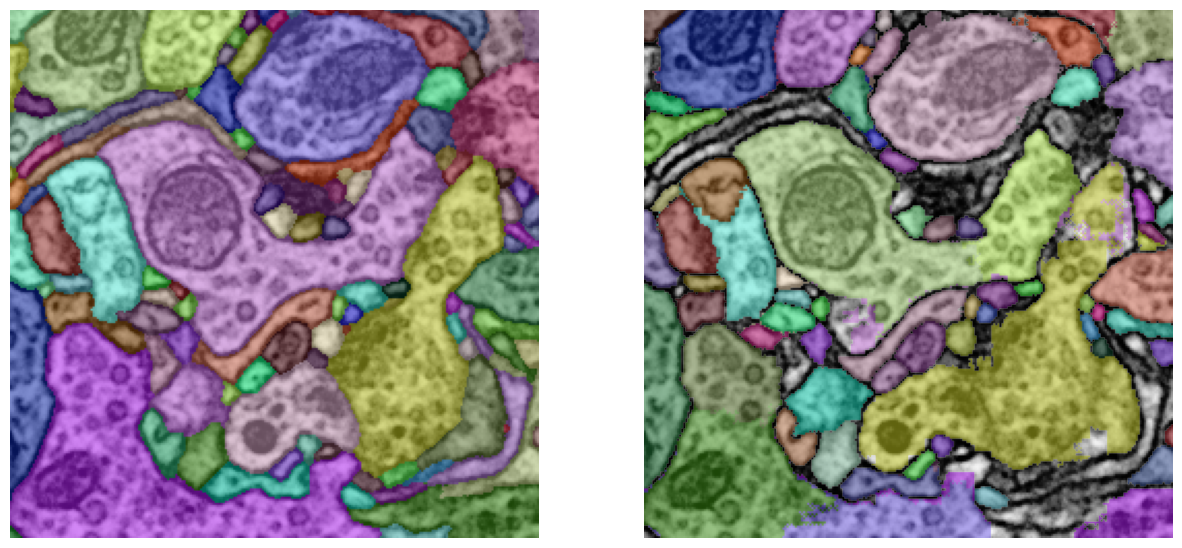

In [60]:
image = to_rgb(ex_video_1r[0])
annot = ex_annot_1[0]

masks_ft = mask_generator_ft_vid.generate(image.astype(np.float16))
print(len(masks_ft), "segments")

fig, axs = plt.subplots(1, 2, figsize=(15, 15))

plt.sca(axs[0])
plt.imshow(image)
show_anns(annot, borders=False)
plt.axis('off')

plt.sca(axs[1])
plt.imshow(image)
show_anns(masks_ft, borders=False)
plt.axis('off')

plt.show()

In [48]:
vi_state = video_predictor.init_state(images=ex_video_1p)
video_predictor.reset_state(vi_state)

In [49]:
for obj_id, mask_dict in enumerate(masks_ft):
    video_predictor.add_new_mask(vi_state, 0, obj_id, mask_dict['segmentation'])

In [50]:
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in video_predictor.propagate_in_video(vi_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }


propagate in video: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.33it/s]


In [72]:
def to_mask_dict(seg_id, mask_array):
    area = mask_array.sum()
    return {'id': seg_id, 'segmentation': mask_array, 'area': area}

video_masks = [[to_mask_dict(seg_id, arr[0]) for seg_id, arr in segs.items()] for segs in video_segments.values()]

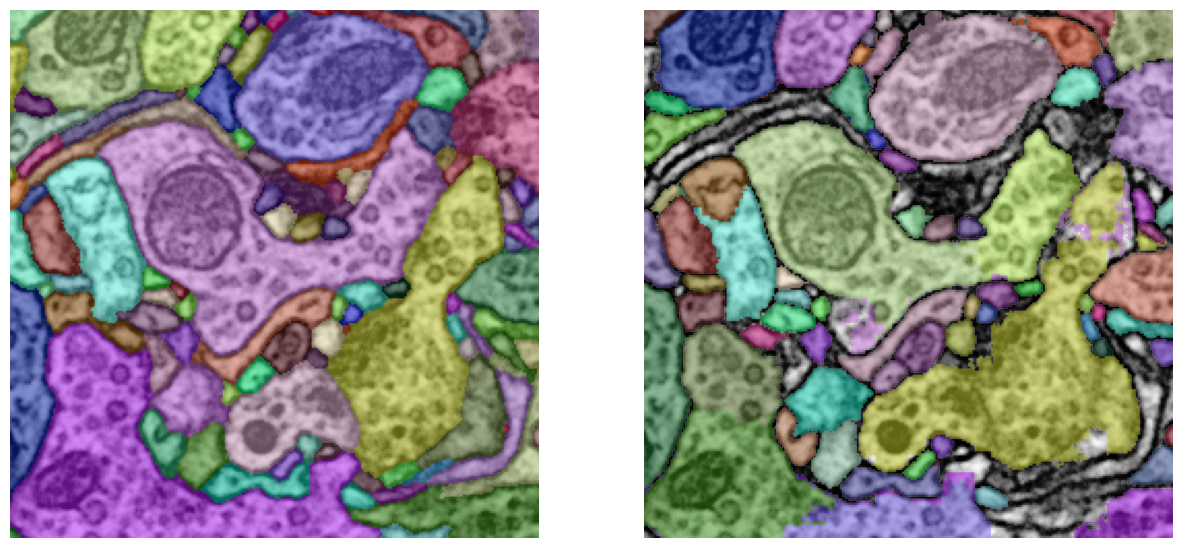

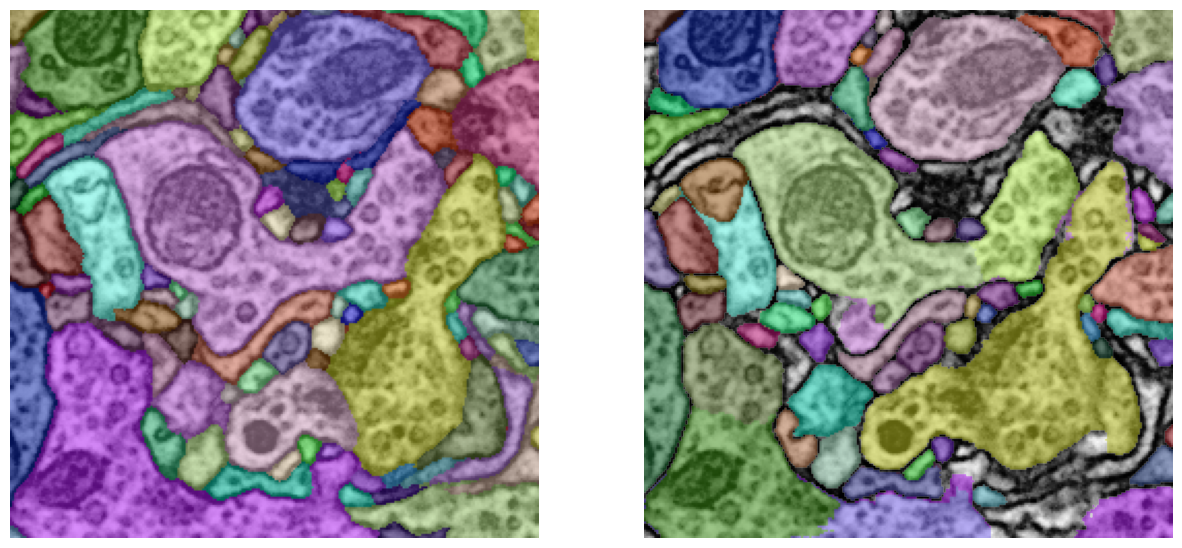

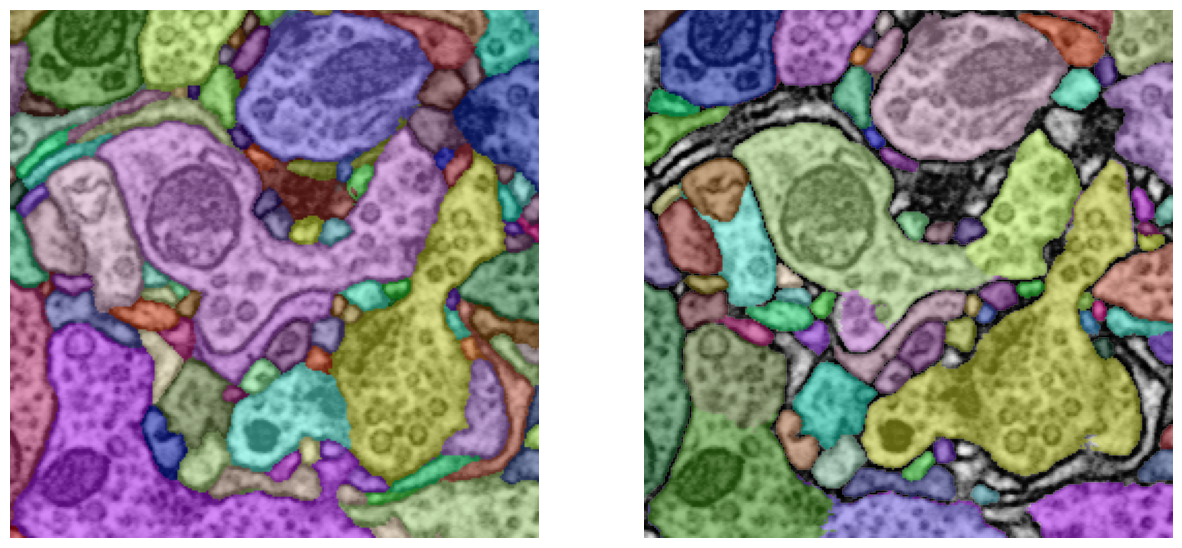

In [75]:
color_map = {}
for i, (img, annot, masks) in enumerate(zip(ex_video_1r, ex_annot_1, video_masks)):
    if i == 3:
        break
    fig, axs = plt.subplots(1, 2, figsize=(15, 15))
    
    plt.sca(axs[0])
    plt.imshow(img, cmap='grey')
    show_anns(annot, borders=False)
    plt.axis('off')
    
    plt.sca(axs[1])
    plt.imshow(img, cmap='grey')
    color_map = show_anns(masks, borders=False, color_map=color_map)
    plt.axis('off')